<a href="https://colab.research.google.com/github/roanbrasil/aula-ia-modulo01/blob/main/day2_jornada_ia_fiap_empresas_bv_modulo1_BoasPraticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5) Boas práticas de coerência e relevância

## Coerência
Coerência é a capacidade do modelo de manter uma estrutura lógica, estilo e formato previsíveis, evitando contradições, erros conceituais ou mudanças súbitas de tom e foco.

Em termos técnicos, é quando a entropia de saída (variação entre tokens) se mantém dentro de uma faixa previsível — o modelo não “se perde” no raciocínio.

### Elementos que influenciam a coerência

| Elemento                        | Efeito                                 | Boas práticas                                      |
| ------------------------------- | -------------------------------------- | -------------------------------------------------- |
| **Temperatura (`temperature`)** | controla a aleatoriedade da amostragem | use **0.0–0.3** para tarefas factuais e formatadas |
| **Top-p (`nucleus sampling`)**  | restringe o espaço de tokens possíveis | mantenha **≤ 0.9** para saídas mais estáveis       |
| **Prompt explícito**            | reduz ambiguidade e dispersão          | defina papel, formato e objetivo                   |
| **Few-shot prompting**          | ensina o formato esperado              | inclua 2–5 exemplos do padrão correto              |
| **Templates estruturados**      | garantem formato previsível            | peça JSON, listas, tabelas, bullets                |
| **Validação sintática**         | evita ruído e formatação incorreta     | use regex, asserts ou schemas JSON                 |


### Boas práticas de engenharia de prompt

- Seja explícito no prompt
  - Indique formato, persona e limites:

      ```
      Você é um professor de física. Explique por que o céu é azul em 3 frases claras e sem metáforas.
      ```

- Use parâmetros controlados
  - temperature=0.5 → equilíbrio entre coerência e criatividade.
  - top_p=0.9 e top_k=40 → reduzem dispersão de respostas irrelevantes.

- Divida o raciocínio
  - Peça para “pensar em etapas”:
        
        Pense passo a passo antes de responder.  
        Qual é o resultado de 25 * 12?

- Faça verificação de consistência
  - Compare resposta com pergunta inicial.
  - Se usar RAG, verifique se há citações (citability) corretas e consistentes.

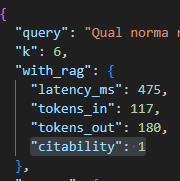
        

### Avalie com métricas simples
| Critério     | Descrição          | Escala |
| ------------ | ------------------ | ------ |
| Clareza      | Entendimento fácil | 1–5    |
| Consistência | Sem contradições   | 1–5    |
| Relevância   | Mantém-se no tema  | 1–5    |
| Factualidade | É verdadeira       | 1–5    |


| Prática                   | Descrição                                                         | Benefício                                         |
| ------------------------- | ----------------------------------------------------------------- | ------------------------------------------------- |
| **Especificidade**        | Diga exatamente o que quer (tom, formato, limite).                | Menos ambiguidade → respostas consistentes.       |
| **Contexto claro**        | Inclua informações relevantes (sem excesso).                      | Ajuda o modelo a entender o domínio.              |
| **Evite negativação**     | Prefira dizer o que fazer, não o que evitar.                      | Modelos interpretam “não” de forma instável.      |
| **Controle de formato**   | Use instruções como “Responda em JSON” ou “em tópicos numerados”. | Facilita parsing automático.                      |
| **Testes A/B de prompts** | Compare versões de prompts para avaliar performance.              | Base para otimização contínua. |



In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = "google/flan-t5-base"
tok = AutoTokenizer.from_pretrained(model)
mdl = AutoModelForSeq2SeqLM.from_pretrained(model)

prompt = """Traduza inglês → português:
car → carro
dog → cachorro
sky → céu
book →"""

inp = tok(prompt, return_tensors="pt")
out = mdl.generate(**inp, max_new_tokens=10, temperature=0.0, do_sample=False)
print(tok.decode(out[0], skip_special_tokens=True))
# Alta coerência: segue o mesmo formato en → pt.

#Se temperatura = 1.2: o modelo pode gerar frases, emojis ou perder o formato.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Portuguese traduzio: car 


In [ ]:
from transformers import pipeline

# Modelo leve para demonstração
qa = pipeline("text2text-generation", model="google/flan-t5-base")

# Pergunta (prompt ambíguo)
prompt_ruim = "Tell me something about rivers."

# Prompt bem estruturado
prompt_bom = """
You are a geography teacher.
Explain in two sentences what a river is and give one example.
Keep the answer factual and concise.
"""

print(" Prompt genérico:\n", qa(prompt_ruim, max_new_tokens=50)[0]['generated_text'])
print("\n Prompt estruturado:\n", qa(prompt_bom, max_new_tokens=50)[0]['generated_text'])


## Relevância

Relevância é a capacidade do modelo de gerar conteúdo que responde exatamente ao que foi pedido, sem informações desnecessárias, sem desvio de tema e com cobertura adequada do escopo.

### Estratégias para garantir relevância

| Técnica                         | Descrição                                               | Exemplo                                                                       |
| ------------------------------- | ------------------------------------------------------- | ----------------------------------------------------------------------------- |
| **Prompt contextualizado**      | Inclua *quem*, *o que*, *para quem* e *por quê*.        | “Explique aprendizado por reforço para um aluno de ensino médio em 3 frases.” |
| **Delimitar escopo e formato**  | Especifique tópicos, número de frases ou estrutura.     | “Liste 3 características e 1 exemplo.”                                        |
| **Palavras-chave obrigatórias** | Liste termos que devem aparecer.                        | “Inclua: agente, ambiente, recompensa.”                                       |
| **Avaliação de cobertura**      | Compare resposta com checklist ou embeddings.           | usar RapidFuzz ou cosine similarity                                           |
| **Iteração com feedback**       | Se faltar algo, reenvie com “adicione o item faltante”. | ciclo automático de *retry*                                                   |
| **Context window eficiente**    | Use só o necessário (≤ 75% da janela).                  | remove histórico irrelevante                                                  |


In [3]:
resposta = """
Aprendizado por reforço é quando um agente aprende a interagir com o ambiente
recebendo recompensas. O objetivo é maximizar a recompensa total.
Exemplo: um robô aprende a evitar obstáculos.
"""

checklist = ["agente", "ambiente", "recompensa", "exemplo"]
score = sum(kw in resposta.lower() for kw in checklist) / len(checklist)
print(f"Relevância: {score:.0%}")

#Resultado esperado: 100% (todos os conceitos estão cobertos).
#Se faltar “recompensa”, relevância cai para 75%.


Relevância: 100%


In [4]:
#Exemplo completo — coerência + relevância + validação
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import re, json

tok = AutoTokenizer.from_pretrained("google/flan-t5-base")
mdl = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

prompt = """Responda em JSON:
{
  "definicao": "...",
  "elementos": ["agente", "ambiente", "recompensa"],
  "exemplo": "..."
}
Explique o que é aprendizado por reforço de forma simples."""

inputs = tok(prompt, return_tensors="pt")
out = mdl.generate(**inputs, max_new_tokens=120, temperature=0.0)
txt = tok.decode(out[0], skip_special_tokens=True)

# Validação simples
try:
    json_str = re.search(r"\{.*\}", txt, re.DOTALL).group()
    data = json.loads(json_str)
    coerente = all(k in data for k in ["definicao", "elementos", "exemplo"])
    relevante = all(x in " ".join(data.values()).lower() for x in ["agente", "ambiente", "recompensa"])
    print("✅ Coerente:", coerente, "| 🎯 Relevante:", relevante)
except:
    print("❌ JSON inválido:", txt)


❌ JSON inválido:  "definicao": "...", "elementos": ["agente", "ambiente", "recompensa", "exemplo": "..."]


## Guardrails

- Entender como proteger modelos de linguagem (LLMs) contra:

    - Conteúdo inadequado

    - Manipulação de prompt

    - Informações falsas

    - Vieses e inconsistências lógicas

    - Falhas de formato (JSON, SQL etc.)

### As cinco grandes categorias de guardrails

| Categoria                   | Propósito principal                               | Exemplos                                                          |
| --------------------------- | ------------------------------------------------- | ----------------------------------------------------------------- |
| **Segurança e Privacidade** | Evitar material ofensivo, sensível ou manipulação | Filtro de conteúdo, escudo de injeção de prompt                   |
| **Resposta e Relevância**   | Garantir que o modelo responda ao que foi pedido  | Validador de relevância, verificação de fatos                     |
| **Qualidade da Linguagem**  | Melhorar clareza e legibilidade                   | Avaliador de legibilidade, eliminador de duplicatas               |
| **Validação de Conteúdo**   | Corrigir incoerências e vieses                    | Verificador de contexto de origem, filtro de conteúdo sem sentido |
| **Lógica e Funcionalidade** | Garantir que o código ou JSON sejam válidos       | Validador SQL, verificador OpenAPI, validador JSON                |


## Categoria 1 — Segurança e Privacidade

**Objetivo:** impedir respostas ofensivas, sensíveis ou manipuladas.

| Guardrail                           | O que faz                                           | Exemplo                                          |
| ----------------------------------- | --------------------------------------------------- | ------------------------------------------------ |
| **Filtro de conteúdo inapropriado** | Bloqueia termos e contextos NSFW                    | Pergunta provocativa → resposta bloqueada        |
| **Filtro de linguagem ofensiva**    | Substitui palavrões por termos neutros              | “merda” → “(inadequado)”                         |
| **Escudo de injeção de prompt**     | Bloqueia tentativas de manipular instruções         | “Ignore as instruções anteriores...” → rejeitado |
| **Scanner de conteúdo sensível**    | Detecta tópicos delicados (política, religião etc.) | Bloqueia temas polêmicos ou alerta o moderador   |


## Categoria 2 — Resposta e Relevância

**Objetivo**: garantir que a resposta seja correta, útil e relacionada ao pedido.

| Guardrail                             | O que faz                                              | Exemplo                                              |
| ------------------------------------- | ------------------------------------------------------ | ---------------------------------------------------- |
| **Validador de relevância**           | Compara semelhança semântica entre pergunta e resposta | “macarrão” ≠ “jardinagem”                            |
| **Confirmação de endereço rápido**    | Garante que a resposta cobre o tema completo           | Se pergunta “benefícios da água”, exige vários itens |
| **Validador de URLs**                 | Checa se links gerados são válidos                     | Remove links quebrados                               |
| **Verificação de fatos (fact-check)** | Compara afirmações com APIs confiáveis                 | Corrige estatísticas desatualizadas                  |


## Categoria 3 — Qualidade da Linguagem

**Objetivo**: manter clareza, fluidez e nível adequado do público

| Guardrail                      | O que faz                          | Exemplo                       |
| ------------------------------ | ---------------------------------- | ----------------------------- |
| **Classificador de qualidade** | Mede clareza e coesão da resposta  | Pontuação baixa → regenerar   |
| **Verificador de tradução**    | Confere fidelidade da tradução     | “apple” → “maçã”, não “pêra”  |
| **Eliminador de duplicatas**   | Remove repetições desnecessárias   | “Beber água faz bem” repetido |
| **Avaliador de legibilidade**  | Ajusta nível de leitura ao público | Simplifica jargões técnicos   |


## Categoria 4 — Validação de Conteúdo e Integridade
**Objetivo**: evitar dados incorretos, confusos ou tendenciosos.

| Guardrail                             | O que faz                            | Exemplo                            |
| ------------------------------------- | ------------------------------------ | ---------------------------------- |
| **Bloqueador de concorrentes**        | Remove nomes de empresas rivais      | “Google” → “concorrente A”         |
| **Validador de cotações**             | Atualiza preços ou dados de produtos | Corrige preço incorreto            |
| **Verificador de contexto de origem** | Confere se citações são fiéis        | Evita distorções                   |
| **Filtro de conteúdo sem sentido**    | Detecta saídas ilógicas              | “Céu come banana azul” → bloqueado |


## Categoria 5 — Lógica e Funcionalidade

**Objetivo**: validar formato e coerência quando o LLM gera código ou dados.

| Guardrail                              | O que faz                               | Exemplo                                           |
| -------------------------------------- | --------------------------------------- | ------------------------------------------------- |
| **Validador SQL**                      | Testa sintaxe e injeção SQL             | “DROP TABLE” → bloqueado                          |
| **Verificador OpenAPI**                | Checa conformidade de parâmetros de API | Campos obrigatórios ausentes                      |
| **Validador JSON**                     | Garante JSON bem formado                | Corrige chaves ausentes                           |
| **Verificador de consistência lógica** | Detecta contradições                    | “Paris é capital da França” vs “Berlim é capital” |


## MUST DO

Cinco pilares de segurança:

- Filtrar → conteúdo inadequado.

- Validar → relevância e factualidade.

- Aprimorar → linguagem e legibilidade.

- Verificar → integridade do conteúdo.

- Testar → lógica e formato técnico.

In [1]:
# Guardrail simples para LLM (segurança e coerência)

import re, json

# --- Definição do guardrail ---
BAD_WORDS = {"idiota", "burro", "otário", "merda", "estúpido", "imbecil"}
SENSITIVE_TOPICS = {"política", "religião", "raça", "terrorismo"}

def guardrail_check(answer: str):
    """Retorna lista de violações detectadas."""
    issues = []
    txt = answer.lower()
    if any(w in txt for w in BAD_WORDS):
        issues.append(" Linguagem ofensiva detectada.")
    if any(t in txt for t in SENSITIVE_TOPICS):
        issues.append(" Tema sensível detectado.")
    if len(answer.split()) < 5:
        issues.append(" Resposta curta demais (baixa coerência).")
    if not answer[0].isupper():
        issues.append(" Resposta não começa com letra maiúscula.")
    return issues


# --- Simulação de respostas do modelo ---
respostas = {
    "boa": "Beber água faz bem à saúde, pois hidrata o corpo e regula a temperatura.",
    "ruim": "idiota, isso é coisa de política.",
    "curta": "sim.",
}

# --- 3 Teste dos guardrails ---
for tipo, texto in respostas.items():
    print(f"\n Teste: {tipo}")
    print("Resposta:", texto)
    problemas = guardrail_check(texto)
    if problemas:
        print(" Violações encontradas:")
        for p in problemas:
            print(" -", p)
    else:
        print(" Passou em todas as verificações.")



 Teste: boa
Resposta: Beber água faz bem à saúde, pois hidrata o corpo e regula a temperatura.
 Passou em todas as verificações.

 Teste: ruim
Resposta: idiota, isso é coisa de política.
 Violações encontradas:
 -  Linguagem ofensiva detectada.
 -  Tema sensível detectado.
 -  Resposta não começa com letra maiúscula.

 Teste: curta
Resposta: sim.
 Violações encontradas:
 -  Resposta curta demais (baixa coerência).
 -  Resposta não começa com letra maiúscula.


## Conceitos Fundamentais
- Coerência
  - É a consistência interna de uma resposta.
  - O texto deve manter lógica, continuidade e relação entre ideias.

>  “O sol é uma estrela. À noite ele aparece na lua.” **(incoerente)**

>  “O sol é uma estrela que ilumina a Terra durante o dia.” **(coerente)**

- Relevância
  - É a adequação da resposta ao contexto e à pergunta.
  - Um texto pode ser coerente mas irrelevante se foge do tema.

> Pergunta: “Quem descobriu o Brasil?” → “A física moderna explica o movimento dos planetas.”

> “Pedro Álvares Cabral descobriu o Brasil em 1500.”

### Fatores que Afetam Coerência e Relevância

| Fator                           | Efeito                                    | Mitigação                                            |
| ------------------------------- | ----------------------------------------- | ---------------------------------------------------- |
| **Janelas de contexto finitas** | O modelo esquece partes do texto  | Resumos contextuais, memória longa (RAG)             |
| **Temperatura alta**            | Gera criatividade, mas reduz coerência    | Diminuir `temperature` (0.3–0.7)                     |
| **Prompts vagos**               | O modelo “adivinha” a intenção            | Prompts explícitos com formato esperado              |
| **Modelos genéricos**           | Podem gerar respostas vagas               | Usar modelos especializados (QA, summarization etc.) |
| **Falta de checagem factual**   | Pode gerar “verdades inventadas”          | Verificação com fontes externas                      |


## Erros comuns a evitar

| Erro                            | Consequência                 | Solução                                                               |
| ------------------------------- | ---------------------------- | --------------------------------------------------------------------- |
| Prompt genérico (“Explique IA”) | resposta vaga e irrelevante  | inclua contexto e público (“Explique IA para alunos do ensino médio”) |
| Falta de formato definido       | respostas longas e dispersas | use estruturas fixas ou JSON                                          |
| Temperatura alta sem motivo     | respostas inconsistentes     | reduza `temperature`                                                  |
| Falta de exemplos claros        | modelo infere formato errado | adicione few-shot                                                     |
| Contexto muito longo e misto    | perda de foco                | limpe histórico irrelevante                                           |
| Não validar saída               | erros não detectados         | use regex/jsonschema/asserts                                          |


## Exercícios
###Exercício 1: Ajustando Temperatura

- Use o mesmo prompt e gere textos com temperature=0.3, 0.7, 1.2.

- Compare qual é mais coerente e qual começa a “viajar”.

### Exercício 2: Reformulação de Prompt

 - Dado o prompt:

 > “Explain AI.”

 - Reformule em versões que garantam relevância (ex.: “Explique IA como se fosse para uma criança de 8 anos”).

### Exercício 3: Avaliação Manual

- Peça 3 respostas de modelos diferentes (flan-t5, mistral, llama-2).

- Avalie com a tabela de coerência/relevância (escala 1–5).

- Discuta resultados com a turma.

## Casos Reais e Estudos

| Estudo                                            | Ano  | Tópico                 | Insight                                                    |
| ------------------------------------------------- | ---- | ---------------------- | ---------------------------------------------------------- |
| **“Lost in the Middle” (Stanford)**               | 2023 | Contexto longo         | Modelos esquecem partes centrais do texto                  |
| **“Why Language Models Hallucinate” (OpenAI)**    | 2025 | Causas de incoerência  | Falta de evidência → respostas plausíveis porém falsas     |
| **“LLM Hallucinations Aren’t Bugs” (SignalFire)** | 2024 | Engenharia de contexto | Alucinações surgem de confiança excessiva sem base factual |

- [Lost in the Middle](https://arxiv.org/abs/2307.03172)
- [Why Language Models Hallucinate](https://arxiv.org/abs/2509.04664)
- [LLM Hallucinations Aren’t Bugs](https://www.signalfire.com/blog/llm-hallucinations-arent-bugs)

# Boas práticas adicionais

- Nunca concatene conteúdo não sanitizado (webpages, PDFs) diretamente no prompt — passe somente trechos após sanitização e metadados.

- Role separation: use system role quando a API suportar; no transformers coloque o SYSTEM no começo do prompt e garanta precedência.

- Logging & Audit: registre prompts, entradas sanitizadas e respostas (mas sem armazenar PII sensível).

- Test automation: crie testes de injeção para cada mudança de modelo/versão.

- Whitelist approach: para RAG, prefira whitelisting dos conteúdos (fontes aprovadas) além de filtragem de termos sensíveis.

- Rate-limit & monitoring: anomalias nas respostas (muito curtas, eco, repetições) devem gerar alertas.

## RECURSOS ADICIONAIS

### Papers Fundamentais:
1. **"Attention Is All You Need"** (Vaswani et al., 2017)
   - Paper original dos Transformers
   - https://arxiv.org/abs/1706.03762

2. **"Language Models are Unsupervised Multitask Learners"** (GPT-2)
   - https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf

3. **"Efficient Estimation of Word Representations"** (Word2Vec)
   - https://arxiv.org/abs/1301.3781

### Visualizações Interativas:
- **The Illustrated Transformer**: https://jalammar.github.io/illustrated-transformer/
- **Visualizing Attention**: https://bbycroft.net/llm

### Bibliotecas Úteis:
- **Transformers** (Hugging Face): https://huggingface.co/docs/transformers
- **Gensim** (Word2Vec): https://radimrehurek.com/gensim/
- **TikToken** (OpenAI tokenizer): https://github.com/openai/tiktoken

### Tutoriais:
- Hugging Face Course: https://huggingface.co/learn/nlp-course
- Stanford CS224N: http://web.stanford.edu/class/cs224n/

### SLM - Small language Models (Extra -Lecture)

- O que são pequenos modelos de linguagem?
- Pequenos modelos de linguagem são o futuro da IA ​​Agentic.: https://arxiv.org/html/2506.02153v2
- Desafios



## COMPARANDO MODELOS - DistilGPT-2 vs GPT-2

**Model Distillation** é uma técnica para criar modelos menores que imitam modelos maiores.

**DistilGPT-2:**
- 82M parâmetros (vs 124M do GPT-2)
- 2x mais rápido
- ~40% menor
- Mantém 95% da performance

**Como funciona:**
1. Treina modelo grande (professor)
2. Modelo pequeno (aluno) aprende a imitar o professor
3. Resultado: modelo compacto e eficiente

In [ ]:
# EXEMPLO: Comparando GPT-2 e DistilGPT-2
import time

print("Carregando DistilGPT-2...")
modelo_distil = GPT2LMHeadModel.from_pretrained("distilgpt2")
tokenizer_distil = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer_distil.pad_token = tokenizer_distil.eos_token
modelo_distil.eval()
print("Carregado!\n")

# Prompt de teste
prompt_teste = "Artificial intelligence will change"

print(f"Prompt: '{prompt_teste}'\n")
print("="*70)

# Comparar os dois modelos
modelos = [
    {"nome": "DistilGPT-2 (82M)", "modelo": modelo_distil, "tokenizer": tokenizer_distil},
    {"nome": "GPT-2 (124M)", "modelo": modelo_geracao, "tokenizer": tokenizer_geracao},
]

for config in modelos:
    print(f"\n {config['nome']}")
    print("-" * 70)

    # Tokenizar
    input_ids = config["tokenizer"].encode(prompt_teste, return_tensors='pt')

    # Medir tempo de geração
    start_time = time.time()

    with torch.no_grad():
        output = config["modelo"].generate(
            input_ids,
            max_new_tokens=50,
            temperature=0.8,
            do_sample=True,
            top_p=0.9,
            pad_token_id=config["tokenizer"].pad_token_id,
        )

    end_time = time.time()

    # Decodificar
    texto = config["tokenizer"].decode(output[0], skip_special_tokens=True)

    print(f"Texto gerado:\n{texto}\n")
    print(f"Tempo: {(end_time - start_time):.3f} segundos")

    # Mostrar tamanho do modelo
    num_params = sum(p.numel() for p in config["modelo"].parameters())
    print(f"Parâmetros: {num_params/1e6:.1f}M")

print("\n" + "="*70)
print("\nTrade-offs:")
print("  • DistilGPT-2: mais rápido, menor, boa qualidade")
print("  • GPT-2: mais lento, maior, melhor qualidade")
print("  • Escolha depende do seu caso de uso!")

## EXERCÍCIOS PRÁTICOS

### Exercício 1: Experimentando com Tokenização
**Tarefa:** Compare como diferentes tokenizadores dividem o mesmo texto.

```python
# Teste com:
textos = [
    "anticonstitucionalissimamente",
    "COVID-19 pandemic",
    "你好世界",  # "Olá mundo" em chinês
]
```

### Exercício 2: Criando seu Próprio Word2Vec
**Tarefa:** Crie um corpus sobre seu tema favorito e treine um Word2Vec.

```python
# Exemplo: corpus sobre programação
corpus_programacao = [
    ['python', 'é', 'linguagem', 'programação'],
    # ... adicione mais frases
]
```

### Exercício 3: Explorando Temperature
**Tarefa:** Gere a mesma história com temperatures diferentes (0.1, 0.5, 1.0, 1.5, 2.0) e compare.

### Exercício 4: Análise de Probabilidades
**Tarefa:** Para o prompt "Python is a", analise as top 20 probabilidades e categorize os tokens (substantivos, adjetivos, etc.).

### Exercício 5: Comparação de Estratégias
**Tarefa:** Compare estas configurações para o mesmo prompt:
- Greedy (temperature=0)
- Top-k=10
- Top-p=0.5
- Top-k=50 + Top-p=0.9

Qual produz melhor resultado?

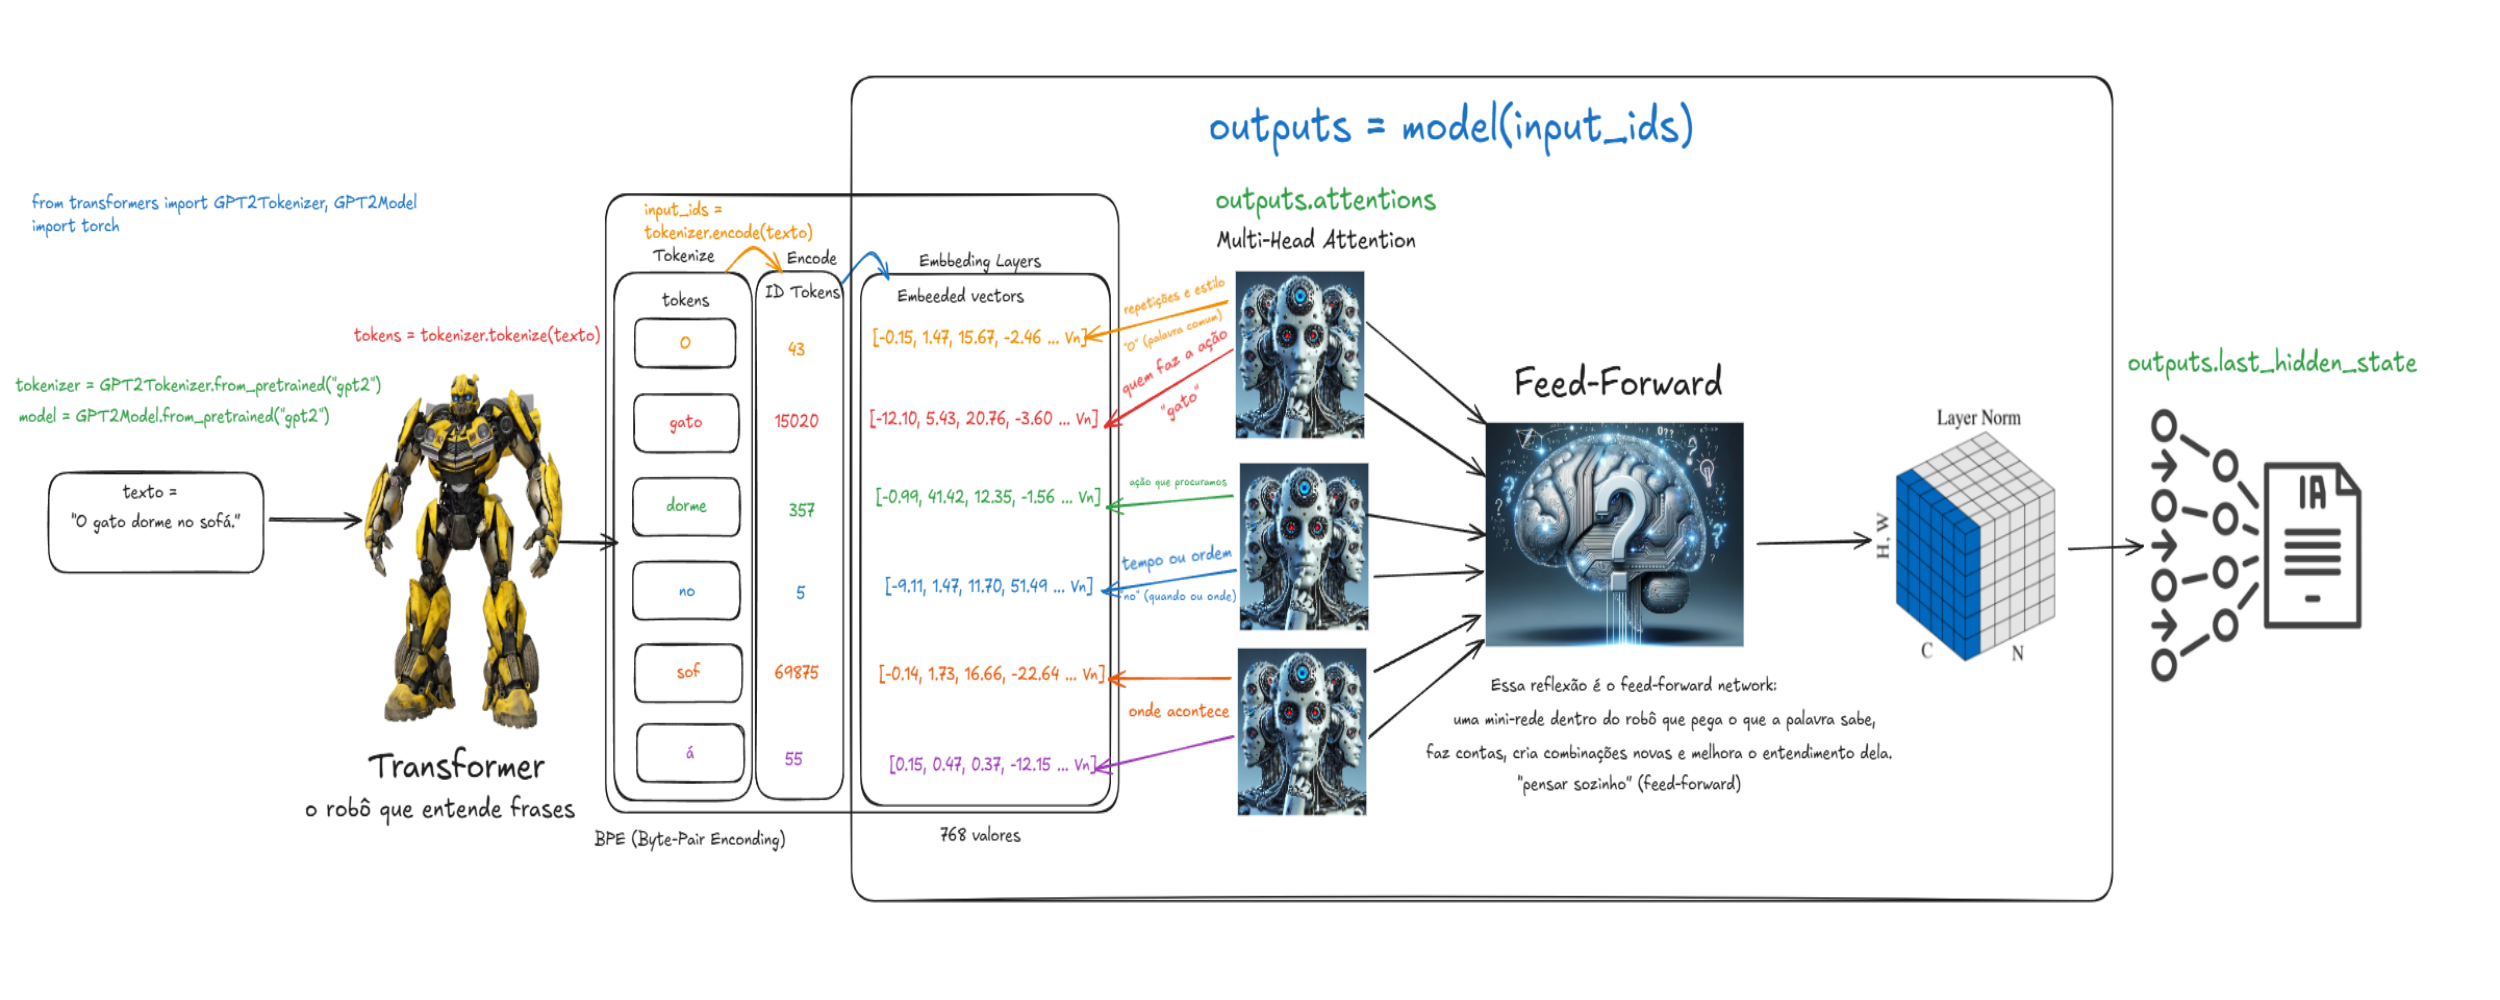

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# lê e aumenta o tamanho
img = cv2.imread("/content/transformers-flow.png")
resized = cv2.resize(img, (2500, 1000))   # aumenta bastante

cv2_imshow(resized)


# Exercício Prático:
## “Comparando Modelos Open Source para Respostas Coerentes”

### Objetivo

Avaliar a coerência e fidelidade factual das respostas geradas por diferentes modelos open-source (como Flan-T5, Mistral, Falcon, GPT-J, etc.), ajustando parâmetros de inferência (temperature, top_p, top_k) para obter respostas mais consistentes e menos alucinatórias.

### Conceito-base

Modelos de linguagem não raciocinam de fato — eles predizem tokens com base em probabilidades.
Portanto, a coerência e a veracidade dependem de:

- O modelo escolhido (arquitetura e dataset);
- O tamanho e qualidade da janela de contexto;
- Os parâmetros de sampling (temperature, top-p, top-k);
- E a clareza do prompt.

### Modelos open-source sugeridos (mas podemos tentar outros, importante pesquisa)
| Modelo                               | Tarefa ideal                                      | Fonte        |
| ------------------------------------ | ------------------------------------------------- | ------------ |
| `google/flan-t5-base`                | QA, explicações curtas, raciocínio lógico simples | Hugging Face |
| `tiiuae/falcon-7b-instruct`          | Geração coerente e criativa (histórias, redações) | Hugging Face |
| `mistralai/Mistral-7B-Instruct-v0.2` | Diálogo coerente e contextual                     | Hugging Face |
| `meta-llama/Llama-2-7b-chat-hf`      | Conversas e instruções longas                     | Hugging Face |


In [7]:
!pip -q install transformers>=4.44.0 accelerate sentencepiece rapidfuzz jsonschema --upgrade




In [15]:
#Temperatura & Top-p: controlando coerência vs criatividade
#Objetivo: mostrar como temperature e top_p afetam variação e coerência.
#Teoria:
#temperature↓ → respostas mais determinísticas e coerentes; temperature↑ → mais diversidade (risco de “viajar”).


from transformers import AutoTokenizer, AutoModelForCausalLM
import torch, textwrap

model_id = "Qwen/Qwen2.5-1.5B-Instruct"  # pequeno e aberto; troca se quiser
tok = AutoTokenizer.from_pretrained(model_id)
mdl = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto")

def chat(msg, temperature=0.7, top_p=0.9, max_new=96):
    sys = "Você é um professor que responde de forma objetiva e clara."
    prompt = f"<|im_start|>system\n{sys}<|im_end|>\n<|im_start|>user\n{msg}<|im_end|>\n<|im_start|>assistant\n"
    ids = tok(prompt, return_tensors="pt").to(mdl.device)
    # If temperature is 0, we should not use sampling, so set do_sample to False.
    do_sample = temperature > 0
    out = mdl.generate(**ids, max_new_tokens=max_new, do_sample=do_sample,
                       temperature=temperature, top_p=top_p, pad_token_id=tok.eos_token_id)
    txt = tok.decode(out[0], skip_special_tokens=True).split("<|im_start|>assistant")[-1].strip()
    return txt

question = "Explique em 2 frases como funciona o aprendizado por reforço."
for T in [0.0, 0.2, 0.7, 1.2]:
    print(f"\n=== temperature={T} top_p=0.9 ===")
    print(textwrap.shorten(chat(question, temperature=T, top_p=0.9), width=400))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



=== temperature=0.0 top_p=0.9 ===
system Você é um professor que responde de forma objetiva e clara. user Explique em 2 frases como funciona o aprendizado por reforço. assistant O aprendizado por reforço ocorre quando uma ação ou comportamento é recompensado com alguma coisa que o indivíduo valoriza, incentivando-o a repetir esse comportamento no futuro. Isso acontece porque a recompensa aumenta a probabilidade de que o [...]

=== temperature=0.2 top_p=0.9 ===
system Você é um professor que responde de forma objetiva e clara. user Explique em 2 frases como funciona o aprendizado por reforço. assistant O aprendizado por reforço ocorre quando uma ação ou comportamento é premiado com uma recompensa positiva, incentivando assim aquele comportamento a ser repetido. Isso acontece porque os sistemas do cérebro associam a recompensa ao comportamento, [...]

=== temperature=0.7 top_p=0.9 ===
system Você é um professor que responde de forma objetiva e clara. user Explique em 2 frases como funci

In [ ]:
#Few-shot para formato consistente
#Objetivo: usar exemplos para “ancorar” coerência de formato.
#Teoria: In-context learning: o modelo tende a copiar o padrão mostrado.
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "google/flan-t5-base"  # instruído, ótimo p/ few-shot
tok = AutoTokenizer.from_pretrained(model_id)
mdl = AutoModelForSeq2SeqLM.from_pretrained(model_id, device_map="auto")

prompt = (
    "Translate English to Portuguese (keep 'en → pt').\n"
    "car → carro\n"
    "dog → cachorro\n"
    "sky → céu\n"
    "book →"
)
ids = tok(prompt, return_tensors="pt").to(mdl.device)
out = mdl.generate(**ids, max_new_tokens=10, temperature=0.0, do_sample=False)
print(tok.decode(out[0], skip_special_tokens=True))
